In [39]:
import os
import sys
path_to_this_notebook = os.path.abspath('.')
PATH_TO_PROJECT = path_to_this_notebook[: path_to_this_notebook.find('notebooks')]
sys.path.append(PATH_TO_PROJECT)

from src.metadata_processing.process_sounds_metadata import generate_sounds_metadata
from src.metadata_processing.filters import filter_sounds_metadata_extended
from src.metadata_processing.load_data import load_recordings_metadata, load_sounds
from src.audiodata_processing.process_waves import denoise_recording

from notebooks.analysis.plotting_config import ORDER, COLOR
from src.visualization.plot_softchirps import plot
from src.audiodata_processing.process_waves import butter_highpass_filter 


import pickle
import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
import umap

def compute_projection(features, projection_type, **kwargs):
    if str(projection_type).lower() == 'tsne':
        transform = TSNE(n_components=2, **kwargs[projection_type.lower()])
        features_projected = transform.fit_transform(features)
    
    elif str(projection_type).lower() == 'umap':
        transform = umap.UMAP(n_components=2, **kwargs[projection_type.lower()])
        features_projected = transform.fit_transform(features)
    elif projection_type is None:
        features_projected = np.array(features)
        #print(features_projected)
    features_projected = pd.DataFrame(features_projected, columns=['dim#%d' % i 
                                                                   for i in range(features_projected.shape[1])])
    return features_projected
    
def choose_features(features_to_use, sounds_metadata, features, recs_dict):
    if features_to_use == 'all':
        return features
    elif features_to_use == 'mfcc':
        return features[[c for c in features.columns if 'mfcc' in c]]
    elif features_to_use == 'vae':
        raise ValueError
    else:
        return features[features_to_use]
    
    
from src.audiodata_processing.extract_features_from_softchirps import *
from src.audiodata_processing.process_waves import *

def extract_features_sounds_metadata(sounds_metadata, recs_metadata, recs_dict=None, 
                                 sr=22050, win_length=220, n_mfcc=30, denoise=False, **denoising_params):
    features = [None for _ in range(sounds_metadata.shape[0])]
    rec_names_set = sounds_metadata['rec'].unique()
    
    for rec_numb, rec_name in enumerate(rec_names_set):
        print('Loading and processing recording %d/%d' % (rec_numb + 1, len(rec_names_set)))
        rec_path = recs_metadata[recs_metadata['name'] == rec_name]['path'].iloc[0]
        rec = recs_dict[rec_name]  
                    
        rec_sounds_inds = np.where(sounds_metadata['rec'] == rec_name)[0]
        sounds_metadata_in_rec = sounds_metadata[sounds_metadata['rec'] == rec_name]
        features_sounds_in_rec = extract_features(sounds_metadata_in_rec, rec,  sr, win_length, n_mfcc)
        for ind_loc, ind in enumerate(rec_sounds_inds):
            features[ind] = np.copy(features_sounds_in_rec.iloc[ind_loc])
        columns = features_sounds_in_rec.columns
        del(features_sounds_in_rec)
    features = pd.DataFrame(features, columns=columns)
    return features
    

def extract_features(sounds_metadata, rec, sr=22050, win_length=220, n_mfcc=30):
    features = []
    for s, e in sounds_metadata[['s', 'e']].values:
        s_int, e_int = int(sr * s), int(sr * e)
        sound = rec[s_int: e_int]
        
        pitch = compute_pitch(sound, win_length)
        ampl = compute_amplitude(sound, win_length)
        ent = compute_wiener_ent(sound, win_length)
        zero_cross = compute_zero_crossing(sound)
        duration_full = e - s
        
        mfcc_features = librosa.feature.mfcc(sound, n_mfcc=n_mfcc)
        mfcc_features = np.concatenate([mfcc_features.min(1), mfcc_features.mean(1), mfcc_features.max(1)])
        
        all_features = np.stack([pitch, ampl, ent, zero_cross, duration_full] + mfcc_features.tolist())
        features.append(all_features)
    return pd.DataFrame(features, columns=['pitch', 'amplitude', 'éntropy', 'zero crossing', 'duration'] + 
                        np.reshape([('mfcc_min%d' % i, 'mfcc_mean%d' % i, 'mfcc_max%d' % i) for i in range(30)], 
                                   (-1)).tolist())

### Parameter selection

In [13]:
path_to_recordings_metadata = PATH_TO_PROJECT + 'data/'
recordings_metadata_name = 'recordings_metadata.csv'

dates = 'all'
colonies = ['berlinannotated']
experiments = 'all'
stages = ['labeled and checked', 'traced and checked', 'labeled', 'traced']

sr = 22050
rec_denoising_params = {'stationary': False, 'n_fft': 512, 'time_constant_s': 0.05, 
                        'freq_mask_smooth_hz': 500, 'time_mask_smooth_ms': 10}

classes_to_drop = ['weirdo', 'badsplit']
max_sounds_per_class = {'softchirp': 99999999}
max_sound_length = 9000
min_sound_length = 1337
columns_to_copy = ['colony', 'ratids', 'date', 'experiment']

recs_dict_name = '-'.join([c[:3] for c in colonies])

In [14]:
if not os.path.isfile(path_to_this_notebook + '/' + recs_dict_name + '.pickle'):
    recs_metadata, recs_dict = load_recordings_metadata(path_to_recordings_metadata, 
                                                        recordings_metadata_name, 
                                                        dates, colonies, experiments, stages,)
    with open(path_to_this_notebook + '/' + recs_dict_name + '.pickle', 'wb') as f:
        pickle.dump(recs_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    print('Start loading!')
    with open(path_to_this_notebook + '/' + recs_dict_name + '.pickle', 'rb') as f:
        recs_dict = pickle.load(f, )
        print('Loaded recs dict')
    recs_metadata, recs_dict = load_recordings_metadata(path_to_recordings_metadata, 
                                                        recordings_metadata_name, 
                                                        dates, colonies, experiments, stages, 
                                                        preloaded_recs_dict=recs_dict)

if os.path.isfile(path_to_this_notebook + '/' + recs_dict_name + '_denoised' + '.pickle'):
    print('Start loading!')
    try:
        with open(path_to_this_notebook + '/' + recs_dict_name + '_denoised' + '.pickle', 'rb') as f:
            recs_dict_denoised = pickle.load(f)
            print('Loaded recs dict')
    except:
        recs_dict_denoised = {rec_name: denoise_recording(rec, sr, **rec_denoising_params)
                              for rec_name, rec in recs_dict.items()}
        with open(path_to_this_notebook + '/' + recs_dict_name + '_denoised' + '.pickle', 'wb') as f:
            pickle.dump(recs_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    recs_dict_denoised = {rec_name: denoise_recording(rec, sr, **rec_denoising_params)
                              for rec_name, rec in recs_dict.items()}
    with open(path_to_this_notebook + '/' + recs_dict_name + '_denoised' + '.pickle', 'wb') as f:
        pickle.dump(recs_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

Using 1 recordings


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 519.92it/s]


In [15]:
sounds_metadata = generate_sounds_metadata(recs_metadata, classes_to_drop, max_sounds_per_class,
                                               min_sound_length, max_sound_length, columns_to_copy,
                                               sr, print_counts=False)

/home/gr1/Projects/naked-mole-rats/src/metadata_processing/process_sounds_metadata.py:36: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  sounds_metadata = pd.concat(sounds_metadata, 0).reset_index(drop=True)


In [16]:
features = extract_features_sounds_metadata(sounds_metadata, recs_metadata, recs_dict, 
                                            sr=22050, win_length=220, n_mfcc=30)

features_denoised = extract_features_sounds_metadata(sounds_metadata, recs_metadata, recs_dict_denoised, 
                                                     sr=22050, win_length=220, n_mfcc=30)
sounds_npy = load_sounds(sounds_metadata, recs_dict, timestamps='sec')
sounds_npy_denoised = load_sounds(sounds_metadata, recs_dict_denoised, timestamps='sec')

Loading and processing recording 1/1


/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.01851175 -0.02581462 -0.02663767 ... -0.10933728 -0.10459249
 -0.10380661] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.01851175 -0.02581462 -0.02663767 ... -0.10933728 -0.10459249
 -0.10380661] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.03143355 -0.0477629  -0.05366644 ...  0.17536817  0.18362221
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes 

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.06556082 -0.08900624 -0.08279563 ...  0.08300338  0.0789151
  0.08359582] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00017234  0.00059997  0.00127585 ... -0.00870303 -0.01594118
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.00017234  0.00059997  0.00127585 ... -0.00870303 -0.01594118
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.01786989 -0.02452444 -0.02575777 ...  0.11053216  0.12611283
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[0.10194996 0.13298468 0.12441139 ... 0.0050315  0.00118549 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[0.10194996 0.13298468 0.12441139 ... 0.0050315  0.00118549 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_pro

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.31036335 -0.38641435 -0.3232832  ...  0.24522398  0.29727742
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.31036335 -0.38641435 -0.3232832  ...  0.24522398  0.29727742
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.02388402 -0.03676036 -0.02184043 ... -0.03617087 -0.04401418
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes 

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[0.02924944 0.0384162  0.03455415 ... 0.0046013  0.00543064 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.04185976  0.05202016  0.04620021 ... -0.03228305 -0.02559366
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.04185976  0.05202016  0.04620021 ... -0.03228305 -0.02559366
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiod

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.01784148  0.02061971  0.02086196 ... -0.06882376 -0.07107858
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.01784148  0.02061971  0.02086196 ... -0.06882376 -0.07107858
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[0.06054078 0.08074472 0.06982578 ... 0.10752791 0.13087766 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptr

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[0.18555459 0.23419856 0.20480016 ... 0.0841212  0.10408232 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[0.18555459 0.23419856 0.20480016 ... 0.0841212  0.10408232 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.06191861 -0.08241231 -0.07398193 ...  0.06814643  0.07125836
  0.07753386] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_n

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.0071051   0.00389962 -0.0023953  ...  0.0073209   0.01121325
  0.02132796] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[0.02623621 0.02514808 0.0160646  ... 0.02470566 0.02777826 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[0.02623621 0.02514808 0.0160646  ... 0.02470566 0.02777826 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_pro

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.23660202 -0.3014355  -0.25152192 ...  0.21896306  0.22702046
  0.22673632] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.23660202 -0.3014355  -0.25152192 ...  0.21896306  0.22702046
  0.22673632] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.         -0.02297053 -0.02863025 ... -0.00830855 -0.0103468
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes =

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.05112582  0.06977943  0.06270524 ... -0.00259116  0.00099584
  0.00406072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.05112582  0.06977943  0.06270524 ... -0.00259116  0.00099584
  0.00406072] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00685155 -0.00937699 -0.00791197 ... -0.01154847 -0.00981619
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes 

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.0301225  -0.040971   -0.03375481 ... -0.04817849 -0.05447763
 -0.0600611 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00309136 -0.01112363 -0.01321715 ...  0.0002789   0.0015374
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.00309136 -0.01112363 -0.01321715 ...  0.0002789   0.0015374
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/a

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[0.         0.03281216 0.04248114 ... 0.06881513 0.06509952 0.06181507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[0.         0.03281216 0.04248114 ... 0.06881513 0.06509952 0.06181507] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00742858 -0.00898411 -0.00682127 ... -0.00056869 -0.00093064
 -0.0021647 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_n

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[0.03947463 0.05155383 0.04342984 ... 0.0229894  0.03840765 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[0.03947463 0.05155383 0.04342984 ... 0.0229894  0.03840765 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.15768328 -0.19664858 -0.18159205 ...  0.1876705   0.24105266
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_n

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.08892472  0.12069301  0.11202523 ... -0.11797733 -0.13595578
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.0709958  -0.08751716 -0.07517355 ... -0.20505199 -0.25161657
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.0709958  -0.08751716 -0.07517355 ... -0.20505199 -0.25161657
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.01595074 -0.01976906 -0.01403025 ... -0.00874838 -0.00395574
  0.00414968] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.02310969 -0.02814149 -0.0228818  ...  0.07633599  0.06946744
  0.07520603] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.02310969 -0.02814149 -0.0228818  ...  0.07633599  0.06946744
  0.07520603] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.12885387 -0.16610317 -0.14892246 ...  0.04702829  0.06344328
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.          0.22726323  0.28856105 ... -0.43515992 -0.41817576
 -0.49248579] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.          0.22726323  0.28856105 ... -0.43515992 -0.41817576
 -0.49248579] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.08363992  0.11331987  0.10481915 ... -0.02899087 -0.0293882
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.08363992  0.11331987  0.10481915 ... -0.02899087 -0.0293882
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.03050543  0.0382184   0.0335761  ... -0.00543589 -0.00447723
 -0.00613656] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = 

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00695297 -0.0123737  -0.01430999 ... -0.16666715 -0.19125868
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.00695297 -0.0123737  -0.01430999 ... -0.16666715 -0.19125868
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[0.         0.0578939  0.08252967 ... 0.12351415 0.12184042 0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptr

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[0.         0.0070156  0.01577978 ... 0.06486654 0.06334283 0.05381322] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.0772503   0.10927075  0.10918332 ... -0.00678846  0.00153422
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.0772503   0.10927075  0.10918332 ... -0.00678846  0.00153422
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiod

Loading and processing recording 1/1


/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 1.62098480e-05  1.58712475e-05 -1.44237140e-05 ... -4.23463597e-03
  8.84855244e-03 -8.57105061e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.0025814  -0.00221701 -0.00205646 ... -0.00105498 -0.01104289
  0.00741525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.0025814  -0.00221701 -0.00205646 ... -0.00105498 -0.01104289
  0.00741525] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Proj

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-2.71964735e-06 -2.92194143e-06 -2.30978893e-06 ... -5.64086960e-05
  6.59213557e-05 -6.62491627e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-2.71964735e-06 -2.92194143e-06 -2.30978893e-06 ... -5.64086960e-05
  6.59213557e-05 -6.62491627e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.02014339 -0.02593504 -0.01777766 ... -0.00051918 -0.02923533
  0.03324369] as keyword args. From version 0.10 passing these as positional argument

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.00371448  0.00346707  0.00405124 ... -0.00236355  0.00251824
 -0.00227783] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.00371448  0.00346707  0.00405124 ... -0.00236355  0.00251824
 -0.00227783] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.0002487   0.00013641  0.00029761 ... -0.00759281 -0.00380263
 -0.0063516 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes 

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[4.13700823e-08 8.19961778e-08 1.03465583e-07 ... 5.69191263e-02
 4.01632674e-02 6.16333032e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.02040745  0.02258605  0.01667975 ...  0.00234245 -0.01356827
  0.012521  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.02040745  0.02258605  0.01667975 ...  0.00234245 -0.01356827
  0.012521  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/n

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 5.42414449e-05 -5.44847466e-05  3.34464947e-05 ...  9.00469608e-02
  1.13784019e-01  5.31949121e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-4.25907529e-05 -7.22223606e-05 -8.94777957e-05 ...  2.37759946e-04
  4.97453613e-04 -2.11583190e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-4.25907529e-05 -7.22223606e-05 -8.94777957e-05 ...  2.37759946e-04
  4.97453613e-04 -2.11583190e-04] as keyword args. From version 0.10 passing these as positional 

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.05567964  0.05759312 -0.06509726 ... -0.01417778 -0.01627654
 -0.00686723] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.05567964  0.05759312 -0.06509726 ... -0.01417778 -0.01627654
 -0.00686723] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.0237885   0.04210396  0.05090205 ...  0.00131228  0.00820075
 -0.00315697] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes 

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.00756063  0.00954646  0.00770824 ...  0.01817735  0.0181249
 -0.00702319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.00756063  0.00954646  0.00770824 ...  0.01817735  0.0181249
 -0.00702319] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00025964  0.00081526  0.00306249 ...  0.00626646 -0.01456354
  0.01504597] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = 

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-3.70551897e-08 -2.25765024e-07 -3.38860736e-07 ...  2.09484312e-02
  1.61233783e-02  2.83220283e-02] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00038163  0.00042888  0.00088361 ...  0.0045088   0.00520109
  0.00531818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.00038163  0.00042888  0.00088361 ...  0.0045088   0.00520109
  0.00531818] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Proj

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-1.32595196e-06  3.97331837e-05  7.00902896e-05 ...  1.01285596e-03
 -3.06391386e-03  2.98435858e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-1.32595196e-06  3.97331837e-05  7.00902896e-05 ...  1.01285596e-03
 -3.06391386e-03  2.98435858e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 1.71771679e-09  1.93204238e-09  9.74175036e-10 ... -2.36212864e-04
  2.37906224e-04 -2.33107789e-04] as keyword args. From version 0.10 passing thes

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.01862078  0.03465341  0.03709705 ... -0.00035627  0.00032805
 -0.00039741] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.00170715  0.0027563   0.00357937 ...  0.00406954 -0.0028025
  0.00948499] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.00170715  0.0027563   0.00357937 ...  0.00406954 -0.0028025
  0.00948499] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/a

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.00267295 -0.00328595 -0.00395527 ...  0.0416386   0.01788423
  0.03196814] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00428976 -0.00383468 -0.00410936 ... -0.00159289  0.00451411
 -0.00372765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.00428976 -0.00383468 -0.00410936 ... -0.00159289  0.00451411
 -0.00372765] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.00026984  0.00035098  0.0004105  ... -0.02481836 -0.00995144
 -0.029317  ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.0011033  -0.00095856 -0.00086244 ... -0.00016922 -0.00341055
  0.00174524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.0011033  -0.00095856 -0.00086244 ... -0.00016922 -0.00341055
  0.00174524] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00115964 -0.00101322 -0.00136889 ...  0.00066027 -0.00273176
  0.00121226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.00115964 -0.00101322 -0.00136889 ...  0.00066027 -0.00273176
  0.00121226] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.00281346  0.00074148 -0.00223622 ...  0.00601049  0.00190321
  0.00489087] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes 

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.00010497  0.00011818  0.00013021 ... -0.00013131 -0.00031183
  0.00062791] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-1.00987480e-07  3.57360249e-09  1.11209806e-07 ...  2.00647438e-04
 -3.30557664e-04  2.54924724e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-1.00987480e-07  3.57360249e-09  1.11209806e-07 ...  2.00647438e-04
 -3.30557664e-04  2.54924724e-04] as keyword args. From version 0.10 passing these as positional arguments will result in

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00146795 -0.00168737 -0.00162609 ... -0.03807862 -0.05982901
  0.0393796 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.00146795 -0.00168737 -0.00162609 ... -0.03807862 -0.05982901
  0.0393796 ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.05062546  0.04041647  0.06333018 ...  0.00506551  0.0041892
  0.01509928] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes =

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.02133648  0.03012061  0.03240675 ...  0.00020215 -0.00076655
  0.00075605] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.02133648  0.03012061  0.03240675 ...  0.00020215 -0.00076655
  0.00075605] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-6.69243984e-05 -2.48035549e-06  6.94897765e-05 ... -4.36286716e-03
  5.42790353e-03  8.82593143e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an erro

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.01373023 -0.01766213 -0.01746505 ... -0.00277659  0.00082583
 -0.00449036] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[-0.01373023 -0.01766213 -0.01746505 ... -0.00277659  0.00082583
 -0.00449036] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-1.29791583e-04 -1.30963024e-04 -8.57104515e-05 ... -8.98413664e-03
 -2.54382236e-04 -9.94625093e-03] as keyword args. From version 0.10 passing these as positional arguments will result in an erro

/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[ 0.00045316 -0.000136    0.00029931 ...  0.00055804  0.01774186
 -0.00777668] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes = piptrack(s_npy, sr = 22050, fmin= 2000, fmax=8000, win_length = win_length)
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/ipykernel_launcher.py:85: FutureWarning: Pass y=[ 0.00045316 -0.000136    0.00029931 ...  0.00055804  0.01774186
 -0.00777668] as keyword args. From version 0.10 passing these as positional arguments will result in an error
/home/gr1/Projects/naked-mole-rats/src/audiodata_processing/extract_features_from_softchirps.py:57: FutureWarning: Pass y=[-0.00174597 -0.00438712 -0.00332355 ... -0.00727334 -0.01424629
  0.00974359] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  pitches, magnitudes 

In [18]:
list(sounds_metadata['rec'].unique())

['berlinannotated_00-00-00_000_0000000.npy']

In [60]:
# Set filters
use_denoising = True

colonies = 'all'
weights = 'all'
dates = 'all'
sexes = 'all' 
ages = 'all'
ranks = 'all' 
ratids = 'all'
excludeids = None 
bodylengths = 'all'
bodylengths2 = 'all' 
sounds_per_rat = [0, np.inf]
max_sounds_per_colony = 10000
types = 'all'
#rec_names = ['damkleinannotated_13-10-21_0000150.npy']
rec_names = 'all'

classes_to_plot = 'all'
classes_to_drop = ['sound', 'sc', 'softchirp']
classes_to_drop = []

mask =  filter_sounds_metadata_extended(sounds_metadata, ratids, excludeids, 
                                   types, colonies, weights, sexes, ages, ranks, dates,
                                   bodylengths, bodylengths2, sounds_per_rat)
if classes_to_plot != 'all':
    mask *= sounds_metadata['cl'].isin(classes_to_plot)
if classes_to_drop:
    mask *= ~sounds_metadata['cl'].isin(classes_to_drop)
if rec_names != 'all' and rec_names is not None:
    mask *= sounds_metadata['rec'].isin(rec_names)
    
mask_select = np.ones(len(sounds_metadata), dtype = 'bool')
id_inds = {}
for col in set(sounds_metadata['colony'][mask]):
    col_inds = np.where((sounds_metadata['colony'] == col) & mask)[0]
    if len(col_inds) > max_sounds_per_colony:
        np.random.shuffle(id_inds)
        mask_select[col_inds[max_sounds_per_colony:]] = False
        mask_select[col_inds[max_sounds_per_colony:]] = False
mask *= mask_select
    
sounds_metadata_filtered = sounds_metadata[mask].reset_index(drop=True)
if use_denoising:
    features_filtered = features_denoised[mask].reset_index(drop=True)
    sounds_npy_filtered = [sounds_npy_denoised[i] for i in np.where(mask)[0]]
else:
    features_filtered = features[mask].reset_index(drop=True)
    sounds_npy_filtered = [sounds_npy[i] for i in np.where(mask)[0]]
recs_dict = recs_dict_denoised if use_denoising else recs_dict
print(sounds_metadata_filtered['colony'].value_counts())

berlinannotated    327
Name: colony, dtype: int64


In [61]:
features_to_use = ['duration', 'pitch'] # 'mfcc', 'wave', list of 'pitch', 'duration' etc., 'vae'
features_to_use = 'all'
features_final = choose_features(features_to_use, 
                                 sounds_metadata_filtered, 
                                 features_filtered,
                                 recs_dict)

In [64]:
projection_type = 'tsne'
all_projections_kwargs = {'pca': {'kernel': 'linear'}, 
                          'tsne': {'perplexity': 10.0}, 
                          'umap': {'min_dist': .1, 'metric': 'euclidean', 'n_neighbors': 10} 
                         }
features_final_projected = compute_projection(features_final, projection_type, **all_projections_kwargs)

/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/gr1/miniconda3/envs/nmr/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


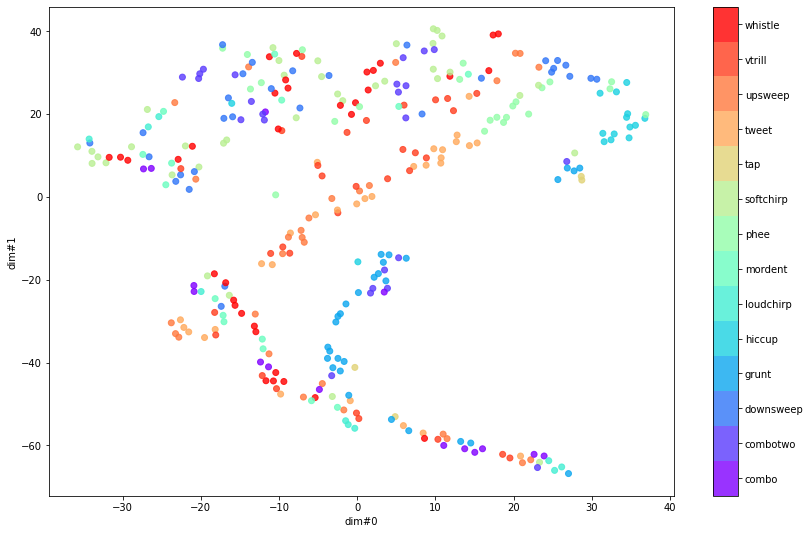

In [65]:
color_by = 'cl'
y_raw = sounds_metadata_filtered[color_by]
y_unique = sorted(set(y_raw))
y = pd.Series([y_unique.index(yi) for yi in y_raw], name=y_raw.name)

group_by_rat = False
plot_color_mean = False
group_color_column = False
plot_ellipses = False

order = ORDER[color_by]
order = None
color_dict = COLOR[color_by]
color_dict = None

plot(features_final_projected, y_raw, sounds_metadata_filtered, 'all', None, group_by_rat, group_color_column, 
     plot_ellipses, plot_color_mean, color_dict, order, sizes_factor=32)

In [146]:
from src.deep_learning.vae import VAE
import torch
from torch.utils.data import DataLoader
from src.deep_learning.util import *


spec_params = {'num_freq_bins': 128,
               'num_time_bins': 128,
               'nperseg': 512, 
               'noverlap': 256, 
               'min_freq': 2000,
               'max_freq': 11025,
               'spec_min_val': -10, 
               'spec_max_val': 0,
               'remove_dc_offset': True, 
               'mel': False, 
               'max_dur': 0.4, 
               'time_stretch': True}


specs = extract_specs_vae(sounds_metadata, sounds_npy, spec_params, sr=22050, fill_value=-1/9999,)
data = [torch.from_numpy(S, ).float() for S in specs]
dl = DataLoader(data, batch_size=128, shuffle=True, sampler=None,)
model = VAE(save_dir='.', lr=5e-4, z_dim=32, model_precision=10.0, device_name="auto")

for epoch in range(1, 541):
    print('Epoch', epoch)
    loss = model.train_epoch(dl)
    #if epoch % 20 == 0:
    #    model.save_state(model_folder + '/model')

In [150]:
def sound_to_spec_vae(sound, p, sr=22050,  fill_value=-1/EPSILON, ):
    
    if p['remove_dc_offset']:
        sound = sound - np.mean(sound)

    f, t, spec = stft(sound, fs=sr, nperseg=p['nperseg'], noverlap=p['noverlap'])
    t *= sr
    spec = np.log(np.abs(spec) + EPSILON)
    spec_pre_interp = np.copy(spec)
    interp = interp2d(t, f, spec_pre_interp, copy=False, bounds_error=False, fill_value=fill_value)

    target_freqs = None
    target_times = None

    if p['mel']: 
        target_freqs = np.linspace(_mel(p['min_freq']), _mel(p['max_freq']), p['num_freq_bins'])
        target_freqs = _inv_mel(target_freqs)
    else:
        target_freqs = np.linspace(p['min_freq'], p['max_freq'], p['num_freq_bins'])
        
    max_dur_int = p['max_dur'] * sr
    duration = len(sound)
    t1, t2 = 0, duration
    if p['time_stretch']:
        duration = np.sqrt(duration * max_dur_int) # stretched duration
    shoulder = 0.5 * (max_dur_int - duration)
    target_times = np.linspace(t1-shoulder, t2+shoulder, p['num_time_bins'])

    # Then interpolate.
    spec = interp(target_times, target_freqs, assume_sorted=True)
    # Normalize.
    spec -= p['spec_min_val']
    spec /= (p['spec_max_val'] - p['spec_min_val'])
    spec = np.clip(spec, 0.0, 1.0)
    
    return spec

def extract_specs_vae(sounds_metadata, sounds, p, sr=22050, fill_value=-1/EPSILON,):
    specs_new = []
    for (s, e, rec_name), sound in zip(sounds_metadata[['s', 'e', 'rec']].values, sounds):
        spec = sound_to_spec_vae(sound, p, sr=sr,  fill_value=fill_value )
        specs_new.append(np.flip(spec, 0))
    return np.array(specs_new)